## Automate prompt engineering with DSPy and Haystack
---

In this example, we will take a look at how we can optimize and automate the prompt engineering process using `Haystack` (to create our generative AI pipeline) and `DSPy` (to optimize our prompts and LM weights).

In [1]:
# For each component, it is essential to know the names of the input and the output. There are several components for various steps
# of the generative AI pipeline that are provided out of the box. This includes components for document stores, embedders, prompt
# builders and generators. You can also build your own component.
!pip install -Uq pip
!pip install -Uq haystack
!pip install -Uq sentence-transformers
!pip install -Uq amazon-bedrock-haystack

In [2]:
# import dependencies
import dspy
import logging
from haystack import Pipeline
from dspy.primitives.prediction import Prediction

# Set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# initialize a haystack pipeline
pipeline = Pipeline()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


In [3]:
# Define the region
AWS_REGION: str = "us-west-2"
BEDROCK_HAIKU_MODELID: str = "anthropic.claude-3-haiku-20240307-v1:0"
SONNET_3_5_MODELID: str = "anthropic.claude-3-5-sonnet-20240620-v1:0"
SONNET_MODELID: str = "anthropic.claude-3-sonnet-20240229-v1:0"
TITAN_TEXT_EMBED_MODELID: str = "amazon.titan-embed-text-v2:0"

In [4]:
import pandas as pd
from datasets import load_dataset

# Load the dataset from Hugging Face

# This dataset contains information about instructions, context for that instruction, a response and the category, 
dataset = load_dataset("vblagoje/PubMedQA_instruction")

# Shuffle and select 1000 samples from the 'train' split
train_data = dataset['train'].shuffle(seed=42).select(range(1000))
df = pd.DataFrame(train_data)

# Save as CSV
csv_path = "PubMedQA_instruction.csv"
df.to_csv(csv_path, index=False)

logger.info(f"Dataset saved to {csv_path}")
df.head()

,instruction,context,response,category
0,Do cC and CXC chemokine levels in children wit...,Chemokines are a superfamily of small peptides...,Initial-phase serum levels of chemokines in pa...,closed_qa
1,Are sAH gene variants associated with obesity-...,The SAH gene locus has recently been proposed ...,We confirm recent evidence that the SAH locus ...,closed_qa
2,Do the functional anatomy of gaze-evoked tinni...,To identify neural sites associated with gaze-...,Patients with GET have plastic changes in mult...,closed_qa
3,Does neighborhood fast-food outlet exposure am...,Greater exposures to fast-food outlets and low...,These findings suggest that efforts to improve...,closed_qa
4,Does conditioned pain modulation predict exerc...,Conditioned pain modulation (CPM) is the conce...,"CPM was attenuated in older adults, as measure...",closed_qa


In [5]:
# view the information on the dataset that is loaded
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  1000 non-null   object
 1   context      1000 non-null   object
 2   response     1000 non-null   object
 3   category     1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB


#### Load the `vblagoje/PubMedQA_instruction` dataset in the in-memory document store

In [6]:
import pandas as pd
from haystack.dataclasses import Document
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack_integrations.components.embedders.amazon_bedrock import (
    AmazonBedrockDocumentEmbedder,
    AmazonBedrockTextEmbedder,
)

# Create an InMemoryDocumentStore with cosine similarity
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

# Initialize the Bedrock document embedder with Titan model
# Note: Replace with your specific Titan model ID
TITAN_TEXT_EMBED_MODELID = "amazon.titan-embed-text-v1"
document_embedder = AmazonBedrockDocumentEmbedder(
    model=TITAN_TEXT_EMBED_MODELID,
    aws_region=AWS_REGION # Specify your AWS region
)

# Add components to the pipeline
pipeline.add_component('embedder', document_embedder)
pipeline.add_component('writer', DocumentWriter(document_store))

# Connect the components
# The embedder will create embeddings that the writer will store
pipeline.connect('embedder.documents', 'writer.documents')


🚅 Components
  - embedder: AmazonBedrockDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - embedder.documents -> writer.documents (List[Document])

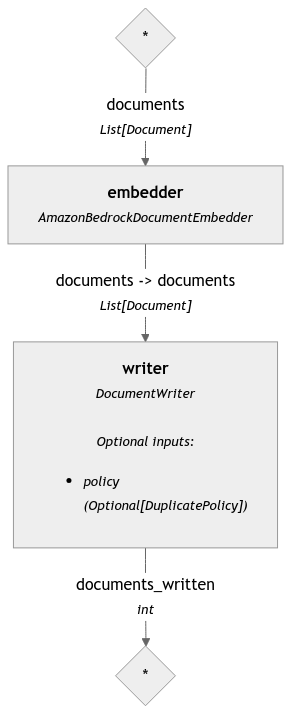

In [7]:
# View the current status of the pipeline
pipeline.show()

In [8]:
import pandas as pd
from haystack.dataclasses import Document

# Load the dataset
df = pd.read_csv(csv_path) 

# Prepare documents
documents = []
for _, row in df.iterrows():
    doc = Document(
        content=f"Instruction: {row['instruction']}\nContext: {row['context']}\nResponse: {row['response']}",
        meta={
            "category": row["category"],
            "question": row["instruction"]
        }
    )
    documents.append(doc)

# Run the pipeline with the documents from the DataFrame
pipeline.run({
    "embedder": {
        "documents": documents
    }
})

Creating embeddings: 100%|██████████| 1000/1000 [01:38<00:00, 10.14it/s]


{'writer': {'documents_written': 1000}}

In [9]:
print(f"Added {len(documents)} documents to the document store.")

Added 1000 documents to the document store.


### Create the haystack pipeline

In [10]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockGenerator

generator = AmazonBedrockGenerator(model=BEDROCK_HAIKU_MODELID)

# initialize the retriever
retriever = InMemoryBM25Retriever(document_store, top_k=3)

template = """
Given the following information, answer the question given below.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

rag_pipeline = Pipeline()
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)

rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: AmazonBedrockGenerator
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

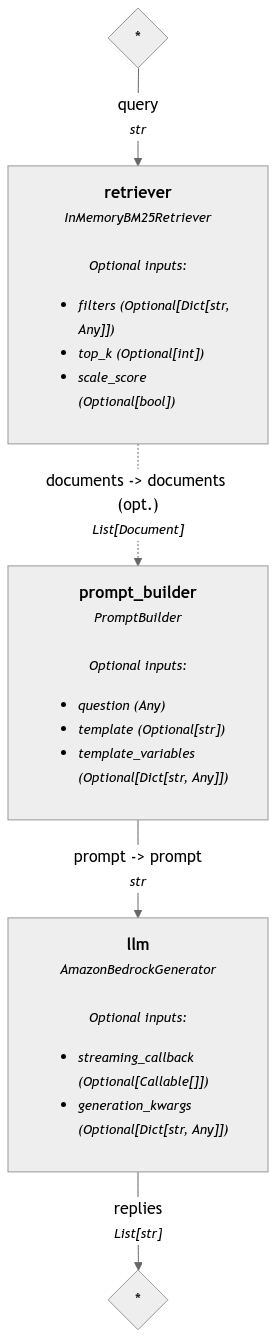

In [11]:
# view the pipeline
rag_pipeline.show()

In [12]:
# run the pipeline and ask a question
question: str = "What is a neurodegenerative disease? Give me examples"
response = rag_pipeline.run({"retriever": {"query": question}, "prompt_builder": {"question": question}})
print(response["llm"]["replies"][0])

A neurodegenerative disease is a condition that primarily affects the neurons (nerve cells) in the brain, leading to the progressive degeneration and/or death of these cells over time. This can result in the impairment of various cognitive, motor, and/or sensory functions.

Examples of neurodegenerative diseases include:

1. Alzheimer's disease: This is the most common form of dementia, characterized by memory loss, cognitive decline, an


Now we have a simple RAG application working. Now we want to optimize the prompts so that we can get more concise responses. We will achieve this using `DSPy`

`DSPy` is a framework designed to algorithmically optimize prompts for Language Models.

### Use DSPy to get more concise answers

In [75]:
def configure_dspy_with_bedrock_model(model_id: str, region: str):
    """
    Configure DSPy with the specified Bedrock model ID.

    Args:
    model_id (str): The Bedrock model ID to use.
    region (str): The AWS region to use. Defaults to "us-west-2".

    Returns:
    None
    """
    try:
        # Create a DSPy language model with the specified model ID
        bedrock_lm = dspy.LM(model_id)
        # Configure DSPy to use this language model
        dspy.configure(lm=bedrock_lm)
        print(f"DSPy configured with model: {model_id}")
        return bedrock_lm
    except Exception as e:
        logger.error(f"Error configuring DSPy with model {model_id}: {e}")
        raise

In [76]:
lm = configure_dspy_with_bedrock_model(BEDROCK_HAIKU_MODELID, AWS_REGION)
lm

DSPy configured with model: anthropic.claude-3-haiku-20240307-v1:0


### Create the dspy signature for question answering
---

We can make changes in the signature to create shorter outputs to questions as we desire

In [77]:
# Now we will create a signature to generate answers that are more concise
# and capture the key components of the question instead of giving lengthy
# responses
# Enhanced signature for generating concise responses
class GenerateConciseResponses(dspy.Signature):
    """Generate extremely concise, information-dense responses to questions."""

    context = dspy.InputField(desc="Relevant information to answer the question")
    question = dspy.InputField()
    response = dspy.OutputField(desc="Provide a concise answer in 15 words or less. Focus on key information only.")

### Create a RAG module to make predictions

In [78]:
class ConciseRAG(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.ChainOfThought(GenerateConciseResponses)

    def retrieve(self, question):
        """
        In this function, we make this so it is possible for us to 
        re use the haystack retriever that already contains all of the indexed 
        documents
        """
        results = retriever.run(query=question)
        passages = [res.content for res in results['documents']]
        return Prediction(passages=passages)

    def forward(self, question):
        context = self.retrieve(question).passages
        prediction = self.generate_answer(context=context, question=question)
        return dspy.Prediction(context=context, answer=prediction.response)

### Prepare training and test data
---

Now we will refer to the previous HF dataset we loaded, and use it to split into training and test examples. We will use these examples in our prompt optimization process

In [46]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 272458
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1000
    })
})

In [47]:
train_data

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 272458
})

In [48]:
from typing import List, Optional
training_examples: List = []
test_examples: List = []
# Access the train split specifically
train_data = dataset['train']

for i, example in enumerate(train_data):
    try:
        # craft the dspy example
        dspy_example = dspy.Example(question=example['instruction'], answer=example['response']).with_inputs('question')
        if i < 20:
            training_examples.append(dspy_example)
        elif i < 70:
            test_examples.append(dspy_example)
        else:
            break
    except Exception as e:
        print(f"Error processing example {i}: {e}")
        continue

In [49]:
print("\nSample training example:")
print(f"Question: {training_examples[0].question}")
print(f"Answer: {training_examples[0].answer}")


Sample training example:
Question: Are group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?
Answer: As ILC2s are elevated in patients with CRSwNP, they may drive nasal polyp formation in CRS. ILC2s are also linked with high tissue and blood eosinophilia and have a potential role in the activation and survival of eosinophils during the Th2 immune response. The association of innate lymphoid cells in CRS provides insights into its pathogenesis.


### Define a metric to optimize for
---

In this section, we will add a metric. Adding and tracking a metric as a part of the prompt optimization process is essential. We will create an example metric to use the HayStack SAS evaluator for the semantic match.

1. `concise_metric` checks for the semantic similarity
1. Uses a custom tiering system to score the length of the outputs.
1. Gives the final score based on the tiered length * semantic similarity score

In [50]:
from haystack.components.evaluators import SASEvaluator

# Initialize the sas evaluator and warm it up
sas_evaluator = SASEvaluator()
sas_evaluator.warm_up()

Average Metric: 18.317131358385087 / 38  (48.2):  76%|███████▌  | 38/50 [15:47<04:59, 24.93s/it]


In [59]:
def concise_metric(example, pred, trace=None) -> float:
    """
    Enhanced metric that strongly favors concise, information-dense responses.
    """
    semantic_similarity = sas_evaluator.run(
        ground_truth_answers=[example.answer], 
        predicted_answers=[pred.answer]
    )["score"]
    
    pred_words = len(pred.answer.split())
    target_words = len(example.answer.split())

    # Enhanced tiered scoring with information density consideration
    if pred_words <= 20:
        length_multiplier = 1.2 
    elif pred_words <= 25:
        length_multiplier = 1.0
    elif pred_words <= 30:
        length_multiplier = 0.7
    elif pred_words <= 35:
        length_multiplier = 0.4
    else:
        length_multiplier = 0.1
    
    # Penalize responses that are much shorter than target (might be incomplete)
    if pred_words < target_words * 0.5:
        completeness_penalty = 0.3
    else:
        completeness_penalty = 0.0
    final_score = (semantic_similarity * length_multiplier) - completeness_penalty
    # Normalize score to be between 0 and 1
    return max(min(final_score, 1.0), 0.0)

In [60]:
# check for how the uncompiled ConciseRAG module performs on the dataset before any optimizations
uncompiled_rag = ConciseRAG()
from dspy.evaluate.evaluate import Evaluate

evaluate = Evaluate(
    metric=concise_metric, devset=test_examples, num_threads=1, display_progress=True, display_table=5
)
evaluate(uncompiled_rag)

Average Metric: 13.407917709648608 / 50  (26.8): 100%|██████████| 50/50 [00:02<00:00, 21.54it/s]

2024/11/12 18:45:21 INFO dspy.evaluate.evaluate: Average Metric: 13.407917709648608 / 50 (26.8%)


,question,example_answer,context,pred_answer,concise_metric
0,Is increased time from neoadjuvant chemoradiation to surgery associated with higher pathologic complete response rates in esophageal cancer?,A longer interval between completion of neoadjuvant chemoradiation and surgery was associated with higher pathologic complete response rates without an impact on surgical morbidity.,['Instruction: Neoadjuvant chemoradiation and duration of chemotherapy before surgical resection for pancreatic cancer: does time interval between radiotherapy and surgery matter?\nContext: Neoadjuvant chemoradiation and chemotherapy...,"Yes, increasing the time interval from neoadjuvant chemoradiation to surgery is associated with higher pathologic complete response rates in esophageal cancer.",✔️ [0.779]
1,Is epileptic focus localization based on resting state interictal MEG recordings feasible irrespective of the presence or absence of spikes?,"Our preliminary results suggest that accurate localization of the epileptogenic focus may be accomplished using noninvasive spontaneous ""resting-state"" recordings of relatively brief duration and without...",['Instruction: Pneumonia in the aged patient: is the clinical presentation atypical?\nContext: Some new studies have questioned the often atypical character of pneumonia in aged patients....,"Unable to provide a response, as the given context does not contain information relevant to the question.",✔️ [0.101]
2,Does seminal Helicobacter pylori treatment improve sperm motility in infertile asthenozoospermic men?,H pylori treatment significantly improves sperm motility in infertile asthenozoospermic men with elevated seminal H pylori IgA.,"['Instruction: Is the 26-kilodalton , AhpC homologue , of Helicobacter pylori also produced by other Helicobacter species?\nContext: The 26 kDa protein, which is an alkyl...",The provided context does not contain information to answer the question.,✔️ [0.026]
3,Does a migrating ciliary gate compartmentalize the site of axoneme assembly in Drosophila spermatids?,"Our findings demonstrate that the ciliary gate can migrate away from the base of the cilium, thereby functioning independently of the centriole and of a...","['Instruction: Does hypoxia transiently sequester mps1 and polo to collagenase-sensitive filaments in Drosophila prometaphase oocytes?\nContext: The protein kinases Mps1 and Polo, which are required for...",Unable to answer due to lack of relevant context.,
4,Is individual Public Transportation Accessibility Positively Associated with Self-Reported Active Commuting?,This study extends the knowledge about the driving forces of using public transportation for commuting by examining the individual public transportation accessibility. Findings suggest that...,['Instruction: Does association of sleep habits with accidents and near miss in United States transportation operators?\nContext: To explore sleep risk factors and their association with...,Unable to determine based on the given context.,


26.82

Now we can see that the metric was evaluated as 42.35, which is pretty low. Now that we have an idea of what the overall dataset it like, we can compile the `ConciseRAG` module using several optimization metrics.

Here, we will use the `BootstrapFewShot` teleprompter/optimizer. 

### Begin module compilation with the `BootstrapFewShot` Optimizer
---

In this example, we will compile our `ConciseRAG()` module with `BootstrapFewShot` optimizer from DSPy (~3 minutes)

View more about this optimizer here: https://dspy.ai/deep-dive/optimizers/bootstrap-fewshot/

In [61]:
from dspy.teleprompt import BootstrapFewShot

optimizer = BootstrapFewShot(metric=concise_metric)

# Now we will compile our RAG module
compiled_rag = optimizer.compile(ConciseRAG(), trainset=training_examples)


 25%|██▌       | 5/20 [00:00<00:00, 15.06it/s]

Bootstrapped 4 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.


In [62]:
# Once our module is compiled, let's re-evaluate all of the prompts
evaluate = Evaluate(
    metric=concise_metric, devset=test_examples, num_threads=1, display_progress=True, display_table=5
)
evaluate(compiled_rag)

Average Metric: 23.98165135085582 / 50  (48.0): 100%|██████████| 50/50 [02:16<00:00,  2.74s/it] 

2024/11/12 18:47:45 INFO dspy.evaluate.evaluate: Average Metric: 23.98165135085582 / 50 (48.0%)


,question,example_answer,context,pred_answer,concise_metric
0,Is increased time from neoadjuvant chemoradiation to surgery associated with higher pathologic complete response rates in esophageal cancer?,A longer interval between completion of neoadjuvant chemoradiation and surgery was associated with higher pathologic complete response rates without an impact on surgical morbidity.,['Instruction: Neoadjuvant chemoradiation and duration of chemotherapy before surgical resection for pancreatic cancer: does time interval between radiotherapy and surgery matter?\nContext: Neoadjuvant chemoradiation and chemotherapy...,"Yes, increased time from neoadjuvant chemoradiation to surgery is associated with higher pathologic complete response rates in esophageal cancer.",✔️ [0.935]
1,Is epileptic focus localization based on resting state interictal MEG recordings feasible irrespective of the presence or absence of spikes?,"Our preliminary results suggest that accurate localization of the epileptogenic focus may be accomplished using noninvasive spontaneous ""resting-state"" recordings of relatively brief duration and without...",['Instruction: Pneumonia in the aged patient: is the clinical presentation atypical?\nContext: Some new studies have questioned the often atypical character of pneumonia in aged patients....,The provided context does not contain information to determine if epileptic focus localization based on resting state interictal MEG recordings is feasible irrespective of the...,✔️ [0.521]
2,Does seminal Helicobacter pylori treatment improve sperm motility in infertile asthenozoospermic men?,H pylori treatment significantly improves sperm motility in infertile asthenozoospermic men with elevated seminal H pylori IgA.,"['Instruction: Is the 26-kilodalton , AhpC homologue , of Helicobacter pylori also produced by other Helicobacter species?\nContext: The 26 kDa protein, which is an alkyl...",The provided context does not contain information to determine if seminal Helicobacter pylori treatment improves sperm motility in infertile asthenozoospermic men.,✔️ [0.711]
3,Does a migrating ciliary gate compartmentalize the site of axoneme assembly in Drosophila spermatids?,"Our findings demonstrate that the ciliary gate can migrate away from the base of the cilium, thereby functioning independently of the centriole and of a...","['Instruction: Does hypoxia transiently sequester mps1 and polo to collagenase-sensitive filaments in Drosophila prometaphase oocytes?\nContext: The protein kinases Mps1 and Polo, which are required for...",The provided context does not contain information to determine if a migrating ciliary gate compartmentalizes the site of axoneme assembly in Drosophila spermatids.,✔️ [0.571]
4,Is individual Public Transportation Accessibility Positively Associated with Self-Reported Active Commuting?,This study extends the knowledge about the driving forces of using public transportation for commuting by examining the individual public transportation accessibility. Findings suggest that...,['Instruction: Does association of sleep habits with accidents and near miss in United States transportation operators?\nContext: To explore sleep risk factors and their association with...,The provided context does not contain information to determine if individual public transportation accessibility is positively associated with self-reported active commuting.,✔️ [0.326]


47.96

Now we can see a significant jump in the metric from `26.82` to `47.96`!

In [82]:
%%capture

static_prompt = inspect_history(n=1).rpartition("---\n")[0]

NameError: name 'inspect_history' is not defined

In [83]:
from haystack.components.builders import AnswerBuilder


template = """
---

Context:
{% for document in documents %}
    «{{ document.content }}»
{% endfor %}

Question: {{question}}
Reasoning: Let's think step by step in order to
"""

new_prompt_builder = PromptBuilder(template=template)

new_retriever = InMemoryBM25Retriever(document_store, top_k=3)
new_generator = AmazonBedrockGenerator(model=BEDROCK_HAIKU_MODELID)

answer_builder = AnswerBuilder(pattern="Answer: (.*)")


optimized_rag_pipeline = Pipeline()
optimized_rag_pipeline.add_component("retriever", new_retriever)
optimized_rag_pipeline.add_component("prompt_builder", new_prompt_builder)
optimized_rag_pipeline.add_component("llm", new_generator)
optimized_rag_pipeline.add_component("answer_builder", answer_builder)

optimized_rag_pipeline.connect("retriever", "prompt_builder.documents")
optimized_rag_pipeline.connect("prompt_builder", "llm")
optimized_rag_pipeline.connect("llm.replies", "answer_builder.replies")


🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: AmazonBedrockGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> answer_builder.replies (List[str])

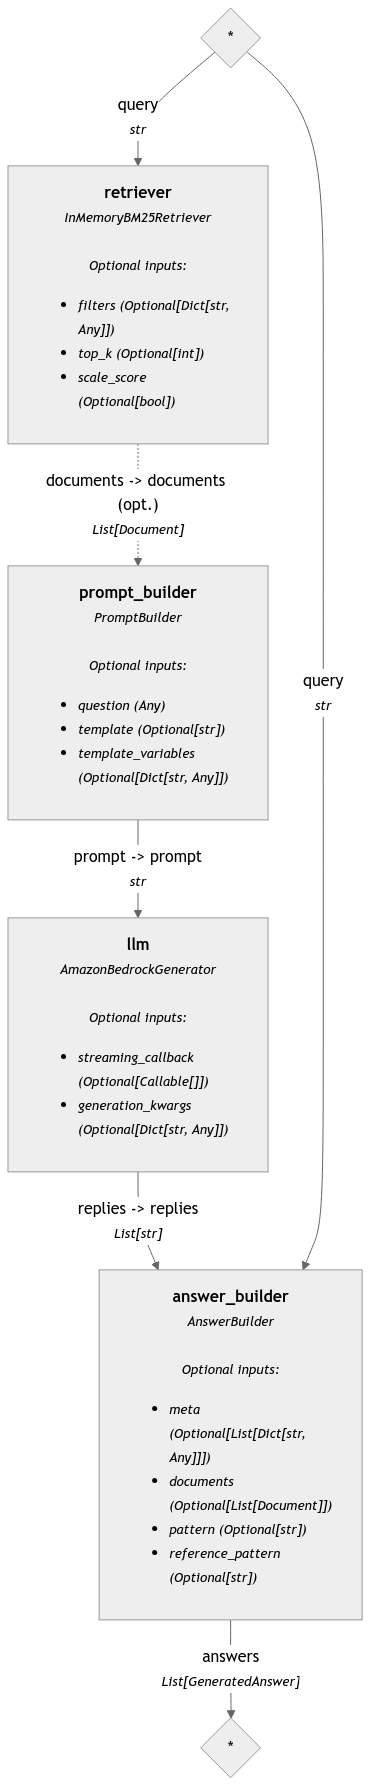

In [86]:
optimized_rag_pipeline.show()

In [85]:
question = "What is a neurodegenerative disease? Give me examples"

response = optimized_rag_pipeline.run({"retriever": {"query": question}, "prompt_builder": {"question": question}, "answer_builder": {"query": question}})

print(response["answer_builder"]["answers"][0].data)